# 实践一下预备知识章节，对应笔记0x02

In [1]:
import torch
print(torch.__version__)

1.8.0


In [2]:
x = torch.arange(20).reshape(4,5)
x

tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])

In [3]:
y = torch.arange(20).reshape(5,4)
y

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15],
        [16, 17, 18, 19]])

In [4]:
v1 = torch.ones(5)
v2 = torch.arange(5)
v1,v2

(tensor([1., 1., 1., 1., 1.]), tensor([0, 1, 2, 3, 4]))

In [5]:
r1 = torch.dot(v1,torch.arange(5,dtype=torch.float))
r2 = torch.mv(x,v2)
r1,r2

(tensor(10.), tensor([ 30,  80, 130, 180]))

## 下面平方和为36，故Frobenius范数为36开平方。

In [6]:
torch.norm(torch.ones((4,9)))

tensor(6.)

In [7]:
import numpy as np
from matplotlib_inline import backend_inline

def f(x):
    return 3 * x ** 2 - 4 * x

def numerical_lim(f, x, h):
    return (f(x + h) - f(x)) / h

h = 0.1
for i in range(5):
    print(f'h={h:.5f}, numerical limit={numerical_lim(f, 1, h):.5f}')
    h *= 0.1

h=0.10000, numerical limit=2.30000
h=0.01000, numerical limit=2.03000
h=0.00100, numerical limit=2.00300
h=0.00010, numerical limit=2.00030
h=0.00001, numerical limit=2.00003


## 可以看到h越小，导数（极限）越接近2。

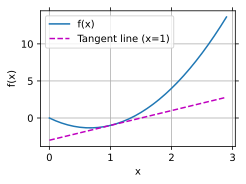

In [8]:
import matplotlib.pyplot as plt

def use_svg_display():
    """使用svg格式在Jupyter中显示绘图"""
    backend_inline.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    """设置matplotlib的图表大小"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """绘制数据点"""
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    # 如果X有一个轴，输出True
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

x = np.arange(0, 3, 0.1)
plot(x, [f(x), 2 * x - 3], 'x', 'f(x)', legend=['f(x)', 'Tangent line (x=1)'])

## 下面是自动微分示例。

In [9]:
x = torch.arange(4.0)
x

tensor([0., 1., 2., 3.])

In [10]:
x.requires_grad_(True)  # 等价于x=torch.arange(4.0,requires_grad=True)，找一块空间存放梯度。
x.grad  # 默认值是None

## y是x的函数

In [11]:
y = 2 * torch.dot(x, x)
y

tensor(28., grad_fn=<MulBackward0>)

## 通过调用反向传播函数来自动计算y关于x每个分量的梯度，并打印这些梯度。

In [12]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

In [13]:
x.grad == 4 * x #函数y关于x的梯度应为4x，验证这个梯度是否计算正确。

tensor([True, True, True, True])

In [14]:
# 下面计算x的l另一个函数，在默认情况下，PyTorch会累积梯度，我们需要清除之前的值
x.grad.zero_()
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

In [15]:
# 对非标量调用backward需要传入一个gradient参数，该参数指定微分函数关于self的梯度。
# 在我们的例子中，我们只想求偏导数的和，所以传递一个1的梯度是合适的
x.grad.zero_()
y = x * x
# 等价于y.backward(torch.ones(len(x)))
y.sum().backward()
x.grad

tensor([0., 2., 4., 6.])

## 下面的反向传播函数计算z=u*x关于x的偏导数，同时将u作为常数处理， 而不是z=x*x*x关于x的偏导数。

In [16]:
x.grad.zero_()
y = x * x
u = y.detach()
z = u * x

z.sum().backward()
x.grad == u , x.grad , y

(tensor([True, True, True, True]),
 tensor([0., 1., 4., 9.]),
 tensor([0., 1., 4., 9.], grad_fn=<MulBackward0>))

In [17]:
x.grad.zero_()
y.sum().backward()
x.grad == 2 * x

tensor([True, True, True, True])

## 下面是概率部分

In [18]:
from torch.distributions import multinomial
fair_probs = torch.ones([6]) / 6  #骰子的6个面的概率
fair_probs, multinomial.Multinomial(1, fair_probs).sample() #在索引i处的值是采样结果中i出现的次数。

(tensor([0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667]),
 tensor([0., 1., 0., 0., 0., 0.]))

In [19]:
multinomial.Multinomial(10, fair_probs).sample() #掷骰子10次的分布情况
counts = multinomial.Multinomial(1000, fair_probs).sample()
counts / 1000  # 相对频率作为估计值

tensor([0.1410, 0.1840, 0.1710, 0.1630, 0.1600, 0.1810])

因为我们是从一个公平的骰子中生成的数据，我们知道每个结果都有真实的概率，大约是六分之一，所以上面输出的估计值看起来不错。
我们也可以看到这些概率如何随着时间的推移收敛到真实概率。 让我们进行500组实验，每组抽取10个样本。

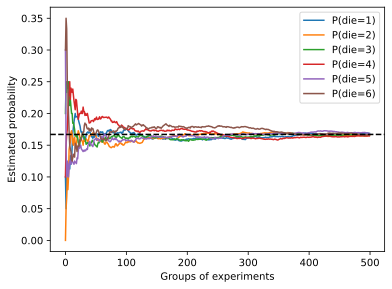

In [21]:
counts = multinomial.Multinomial(10, fair_probs).sample((500,))
cum_counts = counts.cumsum(dim=0)
estimates = cum_counts / cum_counts.sum(dim=1, keepdims=True)

set_figsize((6, 4.5))
for i in range(6):
    plt.plot(estimates[:, i].numpy(),
                 label=("P(die=" + str(i + 1) + ")"))
plt.axhline(y=0.167, color='black', linestyle='dashed')
plt.gca().set_xlabel('Groups of experiments')
plt.gca().set_ylabel('Estimated probability')
plt.legend();

In [23]:
multinomial.Multinomial?